# Code for analysis of Lidar DEMs and landslide data


In [ ]:
# import packages that may or may not be used
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats
from rasterstats import zonal_stats

import rioxarray
from matplotlib_scalebar.scalebar import ScaleBar


import rasterio
from rasterio import features
from shapely.geometry import shape
from shapely.geometry import box

import geopandas as gp

In [2]:
# would whitebox work now...
import whitebox_workflows

from whitebox_workflows import WbEnvironment
wbe = WbEnvironment()
wbe.verbose = True # Let each of the function calls output to stdout.


In [3]:
# define the paths to the lidar data files, 
#I think these are quite similar to the vrt files if saved
data_base_folder='/Users/pmorgan/UW/class/gda/gdanzdata/'

lidar_2016_fn= os.path.join(data_base_folder, f"{2016}.tif")
lidar_2016clip_fn=os.path.join(data_base_folder, f"{2016}_clip.tif")
lidar_2016utm_fn=os.path.join(data_base_folder, f"{2016}_utm.tif")

lidar_2017_fn= os.path.join(data_base_folder, f"{2017}.tif")
lidar_2018_fn= os.path.join(data_base_folder, f"{2018}.tif")

# and the overview new zealand data
linz_dem_proj='/Users/pmorgan/UW/class/gda/gdanzdata/kaik_full_utm.tif'



In [4]:
# read in the relevant polygon datasets
#the small study area
studyzoom_gpkg_fn='/Users/pmorgan/UW/class/gda/gdanzdata/filtered_area.gpkg'
studyzoom_shp_fn='/Users/pmorgan/UW/class/gda/gdanzdata/filtered_area.shp'

studyzoom_gdf=gpd.read_file(studyzoom_gpkg_fn)
studyzoom_gdf=studyzoom_gdf.to_crs('EPSG:32759')
studyzoom_gdf.to_file(studyzoom_shp_fn)

studyzoom_polygon=wbe.read_vector(studyzoom_shp_fn)

# read in the landslide polygons
#landslideshapepolyfn="/Users/pmorgan/UW/class/gda/gdanzdata/landslidepolys/Landslides.shp"
landslideshapepolyfn='/Users/pmorgan/UW/class/gda/gdanzdata/inventory_mean_diff.gpkg'
slide_gdf=gpd.read_file(landslideshapepolyfn)
slide_proj_gdf=slide_gdf.to_crs('EPSG:32759')




In [5]:
slide_proj_gdf.head()

,OBJECTID,LD,Shape_Leng,Shape_Area,area,xLoc,yLoc,mean_diff,geometry
0,13412,0,147.985920,1348.158784,1348.158784,None,None,0.106602,"POLYGON ((728916.504 5315756.778, 728915.663 5..."
1,13473,0,80.741391,407.936149,407.936149,None,None,0.026058,"POLYGON ((728705.038 5316015.623, 728704.600 5..."
2,13465,0,158.667128,1675.133073,1675.133073,None,None,-1.576621,"POLYGON ((729182.519 5315635.024, 729181.302 5..."
3,13466,0,177.412938,1572.323108,1572.323108,None,None,-0.842994,"POLYGON ((729136.188 5315641.165, 729134.479 5..."
4,13467,0,134.624908,727.482580,727.482580,None,None,-0.907851,"POLYGON ((729119.932 5315652.249, 729118.900 5..."


In [9]:
# crop the dem to the filterline for the small area study area
!gdalwarp -cutline $studyzoom_shp_fn -crop_to_cutline $lidar_2016_fn '/Users/pmorgan/UW/class/gda/gdanzdata/2016_clip.tif'

#!gdalwarp -cutline $studyzoom_shp_fn -crop_to_cutline $lidar_2016_fn '/Users/pmorgan/UW/class/gda/gdanzdata/2016_clip.tif'
dst_crs = 'EPSG:32759'
!gdalwarp -overwrite -r cubic -t_srs $dst_crs $lidar_2016_fn $lidar_2016utm_fn


ERROR 1: Output dataset /Users/pmorgan/UW/class/gda/gdanzdata/2016_clip.tif exists,
but some command line options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.

Creating output file that is 10215P x 9592L.
Processing /Users/pmorgan/UW/class/gda/gdanzdata/2016.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [10]:
# Read in the 2016 DEM file.
# and do some processing of it
lidar_2016_dem = wbe.read_raster(lidar_2016utm_fn) # This DEM file is contained in the downloaded data folder.
#lidar_2016_dem = wbe.clip_raster_to_polygon(lidar_2016_dem,studyzoom_polygon) # causes overflow error...

# Fill any NoData holes in the DEM 
lidar_2016_dem = wbe.fill_missing_data(lidar_2016_dem, filter_size=35, exclude_edge_nodata=True)

# create a hillshade image for visualization.
lidar_2016_hs = wbe.multidirectional_hillshade(lidar_2016_dem, full_360_mode=True)
lidar_2016_hs_fn= os.path.join(data_base_folder, f"{2016}_hs.tif")

# calculate the Terrestrial ruggedness index
lidar_2016_TRI = wbe.ruggedness_index(lidar_2016_dem)
lidar_2016_TRI_fn= os.path.join(data_base_folder, f"{2016}_TRI.tif")

# Write the computed rasters to tifs,
wbe.write_raster(lidar_2016_hs, lidar_2016_hs_fn, compress=True)
wbe.write_raster(lidar_2016_TRI, lidar_2016_TRI_fn, compress=True)


# Also compute aspect
aspect_fn=os.path.join(data_base_folder, f"{2016}_aspect.tif")
wb_aspect = wbe.aspect(lidar_2016_dem)
wbe.write_raster(wb_aspect, aspect_fn, compress=True)

#  and slope
slope_fn=os.path.join(data_base_folder, f"{2016}_slope.tif")
wb_slope = wbe.slope(lidar_2016_dem)
wbe.write_raster(wb_slope, slope_fn, compress=True)



********************************************
* Welcome to fill_missing_data             *
* Powered by Whitebox Workflows for Python *
* www.whiteboxgeo.com                      *
********************************************
Finding edge-connected NoData values...
Interpolating data holes...
Interpolating data holes: 0%
Interpolating data holes: 1%
Interpolating data holes: 2%
Interpolating data holes: 3%
Interpolating data holes: 4%
Interpolating data holes: 5%
Interpolating data holes: 6%
Interpolating data holes: 7%
Interpolating data holes: 8%
Interpolating data holes: 9%
Interpolating data holes: 10%
Interpolating data holes: 11%
Interpolating data holes: 12%
Interpolating data holes: 13%
Interpolating data holes: 14%
Interpolating data holes: 15%
Interpolating data holes: 16%
Interpolating data holes: 17%
Interpolating data holes: 18%
Interpolating data holes: 19%
Interpolating data holes: 20%
Interpolating data holes: 21%
Interpolating data holes: 22%
Interpolating data holes: 2

In [11]:
# Sample to raster information to the landslide polygons

#order is read in the raster file with rasterio 
#  - make it a numpy array 
#  - rasterstats to extract mean at polygons 
#  -put those values in the slide gdf

with rio.open(slope_fn) as src:
    r_src=src.read(1)
    zonalstats = zonal_stats(slide_proj_gdf, raster=r_src, affine=src.transform, nodata=src.nodata,stats="mean")
    slide_proj_gdf['mean_slope__2016'] = [stat['mean'] for stat in zonalstats] # chatgptcode...

with rio.open(aspect_fn) as src:
    r_src=src.read(1)
    zonalstats = zonal_stats(slide_proj_gdf, raster=r_src, affine=src.transform, nodata=src.nodata,stats="mean")
    slide_proj_gdf['mean_aspect_2016'] = [stat['mean'] for stat in zonalstats] # chatgptcode...
# I know mean aspect in degrees doesn't really make sense, but this is what we have for now...

with rio.open(lidar_2016_TRI_fn) as src:
    r_src=src.read(1)
    zonalstats = zonal_stats(slide_proj_gdf, raster=r_src, affine=src.transform, nodata=src.nodata,stats="mean")
    slide_proj_gdf['mean_tri_2016'] = [stat['mean'] for stat in zonalstats] # chatgptcode...


In [12]:
slide_proj_gdf.head()

,OBJECTID,LD,Shape_Leng,Shape_Area,area,xLoc,yLoc,mean_diff,geometry,mean_slope__2016,mean_aspect_2016,mean_tri_2016
0,13412,0,147.985920,1348.158784,1348.158784,None,None,0.106602,"POLYGON ((728916.504 5315756.778, 728915.663 5...",41.458831,162.306934,0.831800
1,13473,0,80.741391,407.936149,407.936149,None,None,0.026058,"POLYGON ((728705.038 5316015.623, 728704.600 5...",42.480163,131.227737,0.880439
2,13465,0,158.667128,1675.133073,1675.133073,None,None,-1.576621,"POLYGON ((729182.519 5315635.024, 729181.302 5...",40.681181,174.276938,0.892480
3,13466,0,177.412938,1572.323108,1572.323108,None,None,-0.842994,"POLYGON ((729136.188 5315641.165, 729134.479 5...",39.251848,197.895780,0.854013
4,13467,0,134.624908,727.482580,727.482580,None,None,-0.907851,"POLYGON ((729119.932 5315652.249, 729118.900 5...",37.038005,204.311896,0.758426


In [15]:
slide_proj_gdf.shape

(189, 12)

<Axes: >

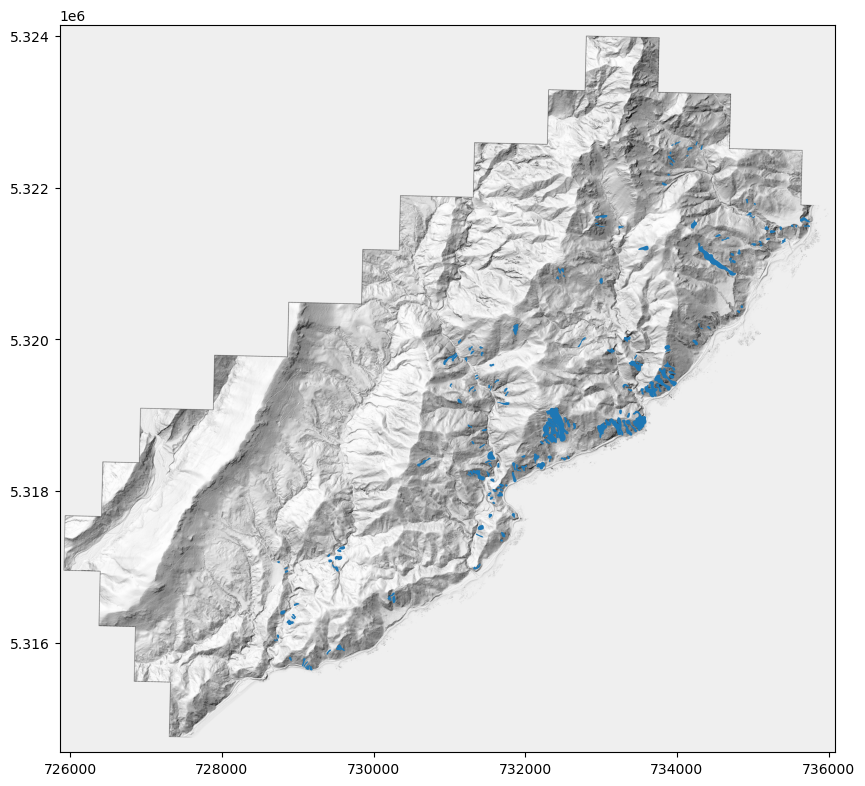

In [16]:
# plot the DEM to see what we're working with
#read the hillshade tiff with rasterio 

src_hs= rio.open(lidar_2016_hs_fn)

fig,axa=plt.subplots(figsize=(10,10))
rio.plot.show(src_tri,ax=axa,cmap='gray')
slide_proj_gdf.plot(ax=axa)


(5318000.0, 5319500.0)

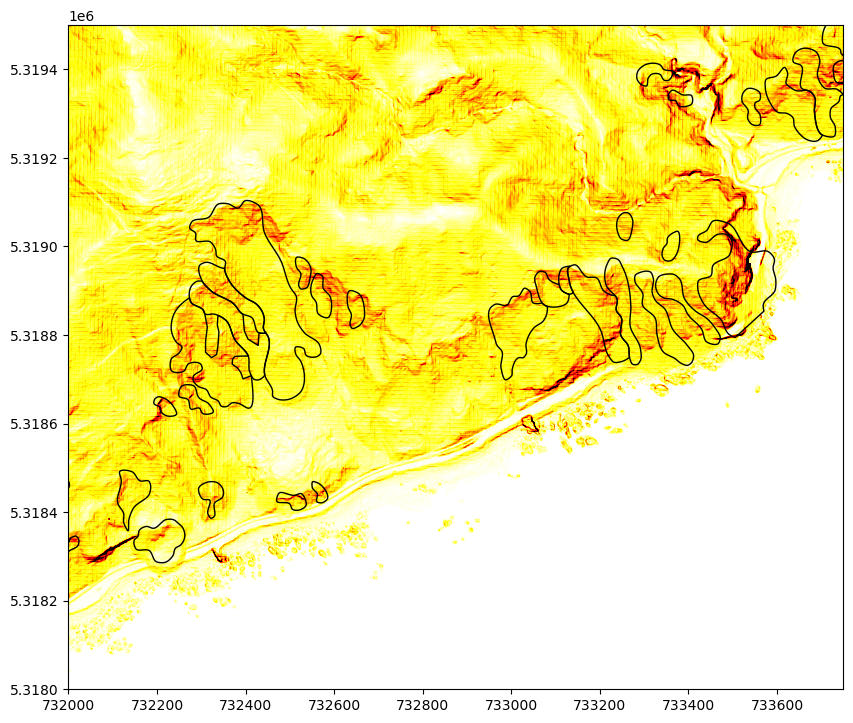

In [34]:
# plot the roughness with some slides
#read the hillshade tiff with rasterio 
src_tri= rio.open(lidar_2016_TRI_fn)


fig,axa=plt.subplots(figsize=(10,10))
rio.plot.show(src_tri,ax=axa,cmap='hot_r', vmin=0,vmax=3)
slide_proj_gdf.plot(ax=axa,facecolor='none')


ex1_bounds_left=732000
ex1_bounds_right=733750
ex1_bounds_top=5319500
ex1_bounds_bottom=5318000

axa.set_xlim(left=ex1_bounds_left, right=ex1_bounds_right)
axa.set_ylim(bottom=ex1_bounds_bottom, top=ex1_bounds_top)





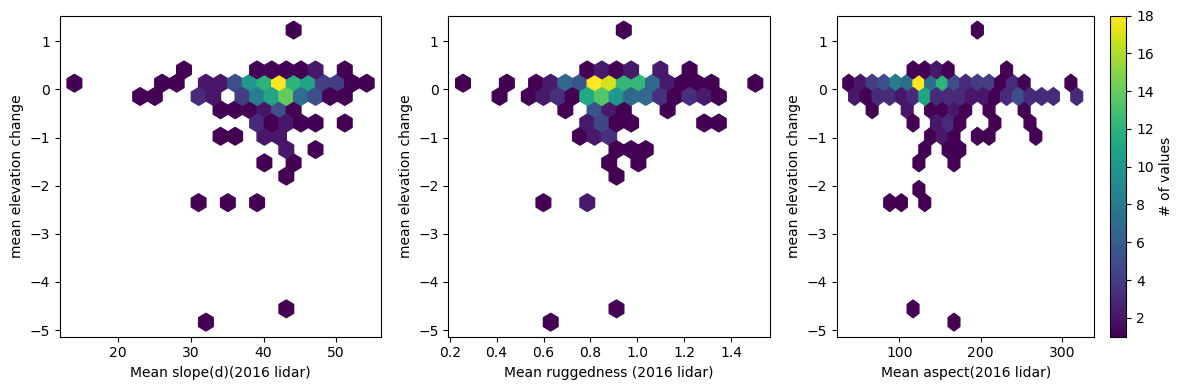

In [26]:
# plot the raster calculation sampled at the landslides. 
# compare roughness, slope, and aspect to the landslide deformation. 

fig, axa = plt.subplots(1,3,figsize=(12,4))
hex=axa[0].hexbin(x = slide_proj_gdf.mean_slope__2016, y = slide_proj_gdf.mean_diff,gridsize = 20,mincnt=1)
#ax1.set_aspect('equal')
#ax1.set(xlim=(0, 8), ylim=(0, 8))
axa[0].set(xlabel=('Mean slope(d)(2016 lidar)'), ylabel=('mean elevation change'))

hex=axa[1].hexbin(x = slide_proj_gdf.mean_tri_2016, y = slide_proj_gdf.mean_diff,gridsize = 20,mincnt=1)
axa[1].set(xlabel=('Mean ruggedness (2016 lidar)'), ylabel=('mean elevation change'))

hex=axa[2].hexbin(x = slide_proj_gdf.mean_aspect_2016, y = slide_proj_gdf.mean_diff,gridsize = 20,mincnt=1)
axa[2].set(xlabel=('Mean aspect(2016 lidar)'), ylabel=('mean elevation change'))


#plt.plot(oneonelinex,oneoneliney,'r--')
cbar=fig.colorbar(hex)
cbar.set_label('# of values')
data_base_folder
plt.savefig('/Users/pmorgan/UW/class/gda/gdanzdata/elevationchange_corr.png',dpi=300)
plt.tight_layout()
plt.show()

In [28]:
# The aspect relationship may be significant, though not likely...